In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('12h-XEwNmJG5-F0Z6mezlGu3mijGARjAr')

     |████████████████████████████████| 71kB 5.1MB/s 


# Getting started with loading data

We are looking at the dataset of images considering different backgrounds and we would train the model to learn how to classify these images. The dataset used is a dataset provided by kaggle. Dataset link: https://www.kaggle.com/puneet6060/intel-image-classification

Its a multi class classification problem and we will try to train the model using convolutional neural network. 

In [3]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification/download'
od.download(dataset_url)

  5%|▍         | 17.0M/346M [00:00<00:03, 110MB/s]

100%|██████████| 346M/346M [00:02<00:00, 165MB/s]


Let's check how many classes we have 


In [4]:
import os

DATA_DIR = './intel-image-classification/seg_train/seg_train'
classes=os.listdir(DATA_DIR)
print(classes)
len(classes)

['buildings', 'mountain', 'street', 'glacier', 'sea', 'forest']


6

Let's get started by importing the libraries we will be needed 

In [5]:
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms as tt

In [6]:
transforms=tt.Compose([tt.Resize((100, 100)), tt.ToTensor()])
dataset = ImageFolder(DATA_DIR, transforms)

## How many images does the training dataset contain?

In [7]:
len(dataset)

14034

# Viewing Dataset 

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [9]:
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 100, 100]) 0


Label:  buildings (0)


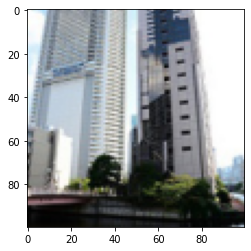

In [10]:
show_example(*dataset[500])

Label:  glacier (2)


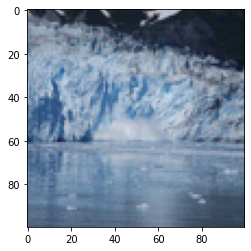

In [11]:
show_example(*dataset[5000])

Label:  sea (4)


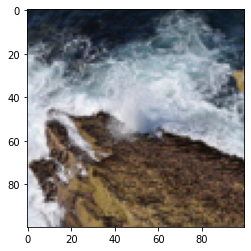

In [12]:
show_example(*dataset[10000])

In [13]:
random_seed=1;
torch.manual_seed(random_seed);
val_size=4000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])


In [14]:
from torch.utils.data.dataloader import DataLoader
batch_size=128


In [15]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(22, 18))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=15).permute(1, 2, 0))
        break

Taking a look at one of the training batch. 

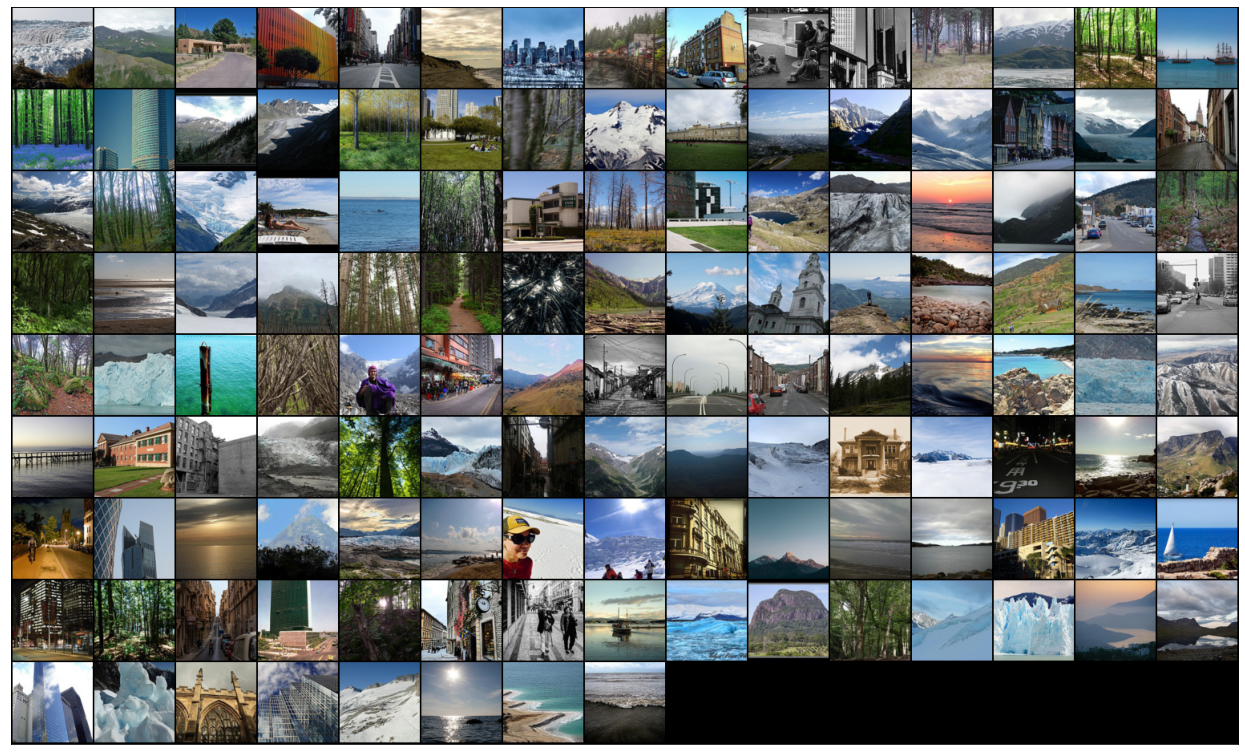

In [17]:
show_batch(train_dl)

Quite a nice views I must say ,there are lot of images and let's get started to making our image classification model. 

# Making the model 

We would be trying to make a multilayered neural network and try to achieve a good accuracy. Let's try ! 

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class IntelClassificationModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 32 x 100 x 100
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 64 x 100 x 100
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 50 x 50

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 128 x 50 x 50
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 128 x 50x 50
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 

            nn.Flatten(), 
            nn.Linear(256*25*25, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 6))
        
    def forward(self, xb):
        return self.network(xb)

In [21]:
model=IntelClassificationModel()
model

IntelClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=160000, out_features=1024, bias=True)
    (16): ReLU()
    (17): Linear(in_features=1024, out_features=512, bias=True)
    (18): ReLU()
    (19): Linear(

Getting the fast running GPUs to train the models be right back. 

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [26]:
model = to_device(IntelClassificationModel(), device)

In [27]:
evaluate(model, val_dl)

{'val_acc': 0.18017578125, 'val_loss': 1.7912101745605469}

Almost a 20 % accuracy , that's as good as hitting a blind shot. Let's pump those numbers up. 

# Training the model 


In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
model = to_device(IntelClassificationModel(), device)

In [30]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
jovian.commit(project="intel-image-classification")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/harshghodkar/intel-image-classification


'https://jovian.ai/harshghodkar/intel-image-classification'

In [32]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [33]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3989, val_loss: 1.1689, val_acc: 0.5449
Epoch [1], train_loss: 1.0593, val_loss: 0.9215, val_acc: 0.6324
Epoch [2], train_loss: 0.8752, val_loss: 0.8888, val_acc: 0.6537
Epoch [3], train_loss: 0.7492, val_loss: 0.8230, val_acc: 0.7008
Epoch [4], train_loss: 0.6549, val_loss: 0.8572, val_acc: 0.6693
Epoch [5], train_loss: 0.5174, val_loss: 0.7421, val_acc: 0.7432
Epoch [6], train_loss: 0.3536, val_loss: 0.7958, val_acc: 0.7444
Epoch [7], train_loss: 0.2346, val_loss: 1.0174, val_acc: 0.7446
Epoch [8], train_loss: 0.1546, val_loss: 1.1381, val_acc: 0.7478
Epoch [9], train_loss: 0.1110, val_loss: 1.2868, val_acc: 0.7392


In [34]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [35]:
jovian.commit(project="intel-image-classification")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/harshghodkar/intel-image-classification


'https://jovian.ai/harshghodkar/intel-image-classification'

In [36]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [37]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

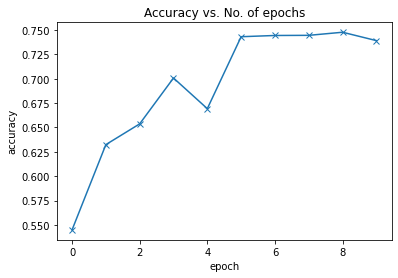

In [38]:
plot_accuracies(history)

In [39]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

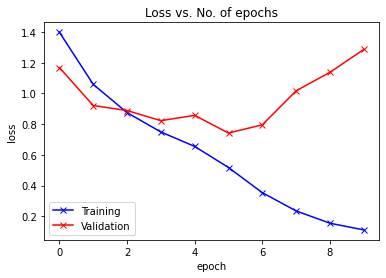

In [40]:
plot_losses(history)

We can see that at the 4th Epoch the model starts overfitting 

# Testing dataset



In [41]:
test_dataset = ImageFolder('intel-image-classification/seg_test/seg_test', transforms)
len(test_dataset)

3000

In [42]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: glacier , Predicted: glacier


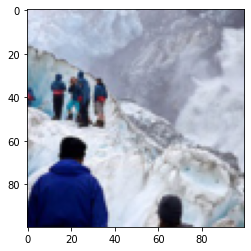

In [43]:
img, label = test_dataset[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: forest , Predicted: forest


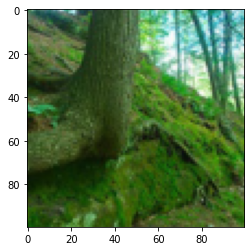

In [44]:
img, label = test_dataset[500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [45]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7371206879615784, 'val_loss': 1.276686191558838}

In [46]:
torch.save(model.state_dict(), 'intel-classification.pth')

In [47]:
jovian.commit(project="intel-image-classification")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/harshghodkar/intel-image-classification


'https://jovian.ai/harshghodkar/intel-image-classification'

# Conclusions 
After completing these course I have undestood the fundamental concepts of Deep Learning and it has provided a novice like me a strong foundation to start up with. Further we could improvise the model via using resnet. Such classification models when made into APIs can help making in much useful apps. 